In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/.virtualenvs/nca-alife-clip/bin/python3


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [10]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [11]:
tgt_imgs = "alife confetti_ball einstein gameoflife gorilla nature neutral_face wrestlers".split(" ")

In [12]:
cfg_default = dict(seed=0, save_dir=None, n_iters_chunk=200,
                   height=32, width=32, dt=0.01, p_drop=0.0, init_state='randn', rollout_steps=64, target_img_path=None, apply_loss='all',
                   n_layers=1, d_state=16, d_embd=64, kernel_size=3,
                   bs=1, lr=3e-4, lr_schedule='constant')

In [19]:
n_seeds = 1

cfgs = []
for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        cfg = cfg_default.copy()
        cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
        cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}')
        cfgs.append(cfg)

for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for dt in [0.001, 0.01, 0.1, 1.]:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(dt=dt)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_dt={dt}')
            cfgs.append(cfg)
            
for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for p_drop in [0.0, 0.1, 0.3, 0.5, 0.9]:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(p_drop=p_drop)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_p_drop={p_drop}')
            cfgs.append(cfg)

for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for init_state in ['point', 'randn', 'zeros']:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(init_state=init_state)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_init_state={init_state}')
            cfgs.append(cfg)

for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for rollout_steps in [32, 64, 128]:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(rollout_steps=rollout_steps)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_rollout_steps={rollout_steps}')
            cfgs.append(cfg)

for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for apply_loss in ['last', 'all']:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(apply_loss=apply_loss)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_apply_loss={apply_loss}')
            cfgs.append(cfg)


for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for n_layers in [1, 2, 4]:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(n_layers=n_layers)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_n_layers={n_layers}')
            cfgs.append(cfg)

for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for d_state in [4, 8, 16, 32]:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(d_state=d_state)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_d_state={d_state}')
            cfgs.append(cfg)

for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for d_embd in [8, 16, 32, 64]:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(d_embd=d_embd)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_d_embd={d_embd}')
            cfgs.append(cfg)


for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for kernel_size in [1, 3, 5, 7]:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(kernel_size=kernel_size)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_kernel_size={kernel_size}')
            cfgs.append(cfg)

for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for bs in [1, 4, 16, 64]:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(bs=bs)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_bs={bs}')
            cfgs.append(cfg)

for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for lr in [3e-4, 1e-3, 3e-3, 1e-2, 3e-2]:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(lr=lr)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_lr={lr}')
            cfgs.append(cfg)

for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for lr_schedule in ['constant', 'cosine_decay']:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(lr_schedule=lr_schedule)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_lr_schedule={lr_schedule}')
            cfgs.append(cfg)

for seed in range(n_seeds):
    for tgt_img in tgt_imgs:
        for hw in [16, 32, 64]:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, target_img_path=f"/home/akarshkumar0101/nca-alife-data/target_imgs/{tgt_img}.png")
            cfg.update(height=hw, width=hw)
            cfg.update(save_dir=f'/home/akarshkumar0101/nca-alife-data/bptt/{tgt_img}_{seed}_hw={hw}')
            cfgs.append(cfg)

In [20]:
commands = experiment_utils.create_commands(cfgs, prefix='python bptt.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python bptt.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/bptt/alife_0"                                  --n_iters_chunk=200 --height=32 --width=32 --dt=0.01  --p_drop=0.0 --init_state="randn" --rollout_steps=64  --target_img_path="/home/akarshkumar0101/nca-alife-data/target_imgs/alife.png"         --apply_loss="all"  --n_layers=1 --d_state=16 --d_embd=64 --kernel_size=3 --bs=1  --lr=0.0003 --lr_schedule="constant"    
python bptt.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/bptt/confetti_ball_0"                          --n_iters_chunk=200 --height=32 --width=32 --dt=0.01  --p_drop=0.0 --init_state="randn" --rollout_steps=64  --target_img_path="/home/akarshkumar0101/nca-alife-data/target_imgs/confetti_ball.png" --apply_loss="all"  --n_layers=1 --d_state=16 --d_embd=64 --kernel_size=3 --bs=1  --lr=0.0003 --lr_schedule="constant"    
python bptt.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/bptt/einstein_0"                               --n_

# Visualize Results

In [5]:
df = []
for p in glob.glob('/home/akarshkumar0101/nca-alife-data/bptt/*'):
    args = util.load_json(p, 'args')
    loss = np.mean(util.load_pkl(p, 'losses'))
    df.append(dict(**args, loss=loss))
df = pd.DataFrame(df)
df

,seed,save_dir,n_iters_chunk,height,width,dt,p_drop,init_state,rollout_steps,target_img_path,...,d_embd,kernel_size,nonlin,n_iters,bs,lr,lr_schedule,weight_decay,clip_grad_norm,loss
0,0,/home/akarshkumar0101/nca-alife-data/bptt/alif...,200,32,32,0.01,0.0,randn,64,/home/akarshkumar0101/nca-alife-data/target_im...,...,64,3,gelu,10000,1,0.0003,constant,0.0,1.0,0.013207
1,0,/home/akarshkumar0101/nca-alife-data/bptt/neut...,200,32,32,0.01,0.0,randn,64,/home/akarshkumar0101/nca-alife-data/target_im...,...,64,3,gelu,10000,64,0.0003,constant,0.0,1.0,0.017081
2,0,/home/akarshkumar0101/nca-alife-data/bptt/eins...,200,32,32,0.01,0.0,randn,64,/home/akarshkumar0101/nca-alife-data/target_im...,...,64,3,gelu,10000,1,0.0003,constant,0.0,1.0,0.007700
3,0,/home/akarshkumar0101/nca-alife-data/bptt/eins...,200,32,32,0.01,0.0,randn,64,/home/akarshkumar0101/nca-alife-data/target_im...,...,64,3,gelu,10000,1,0.0003,constant,0.0,1.0,0.013566
4,0,/home/akarshkumar0101/nca-alife-data/bptt/gori...,200,32,32,0.01,0.0,randn,64,/home/akarshkumar0101/nca-alife-data/target_im...,...,64,3,gelu,10000,16,0.0003,constant,0.0,1.0,0.015988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,0,/home/akarshkumar0101/nca-alife-data/bptt/eins...,200,32,32,0.01,0.0,randn,64,/home/akarshkumar0101/nca-alife-data/target_im...,...,8,3,gelu,10000,1,0.0003,constant,0.0,1.0,0.025056
372,0,/home/akarshkumar0101/nca-alife-data/bptt/alif...,200,32,32,0.01,0.5,randn,64,/home/akarshkumar0101/nca-alife-data/target_im...,...,64,3,gelu,10000,1,0.0003,constant,0.0,1.0,0.017567
373,0,/home/akarshkumar0101/nca-alife-data/bptt/eins...,200,32,32,0.01,0.0,randn,64,/home/akarshkumar0101/nca-alife-data/target_im...,...,64,3,gelu,10000,1,0.0003,constant,0.0,1.0,0.013583
374,0,/home/akarshkumar0101/nca-alife-data/bptt/natu...,200,32,32,0.01,0.0,randn,64,/home/akarshkumar0101/nca-alife-data/target_im...,...,64,3,gelu,10000,16,0.0003,constant,0.0,1.0,0.016336


In [23]:
def target_img_path2target_img_str(a):
    return a.split('/')[-1][:-4]
df['target_img'] = [target_img_path2target_img_str(i) for i in df.target_img_path]
df['target_img'] = df['target_img'].astype(pd.CategoricalDtype(df.target_img.unique(), ordered=True))

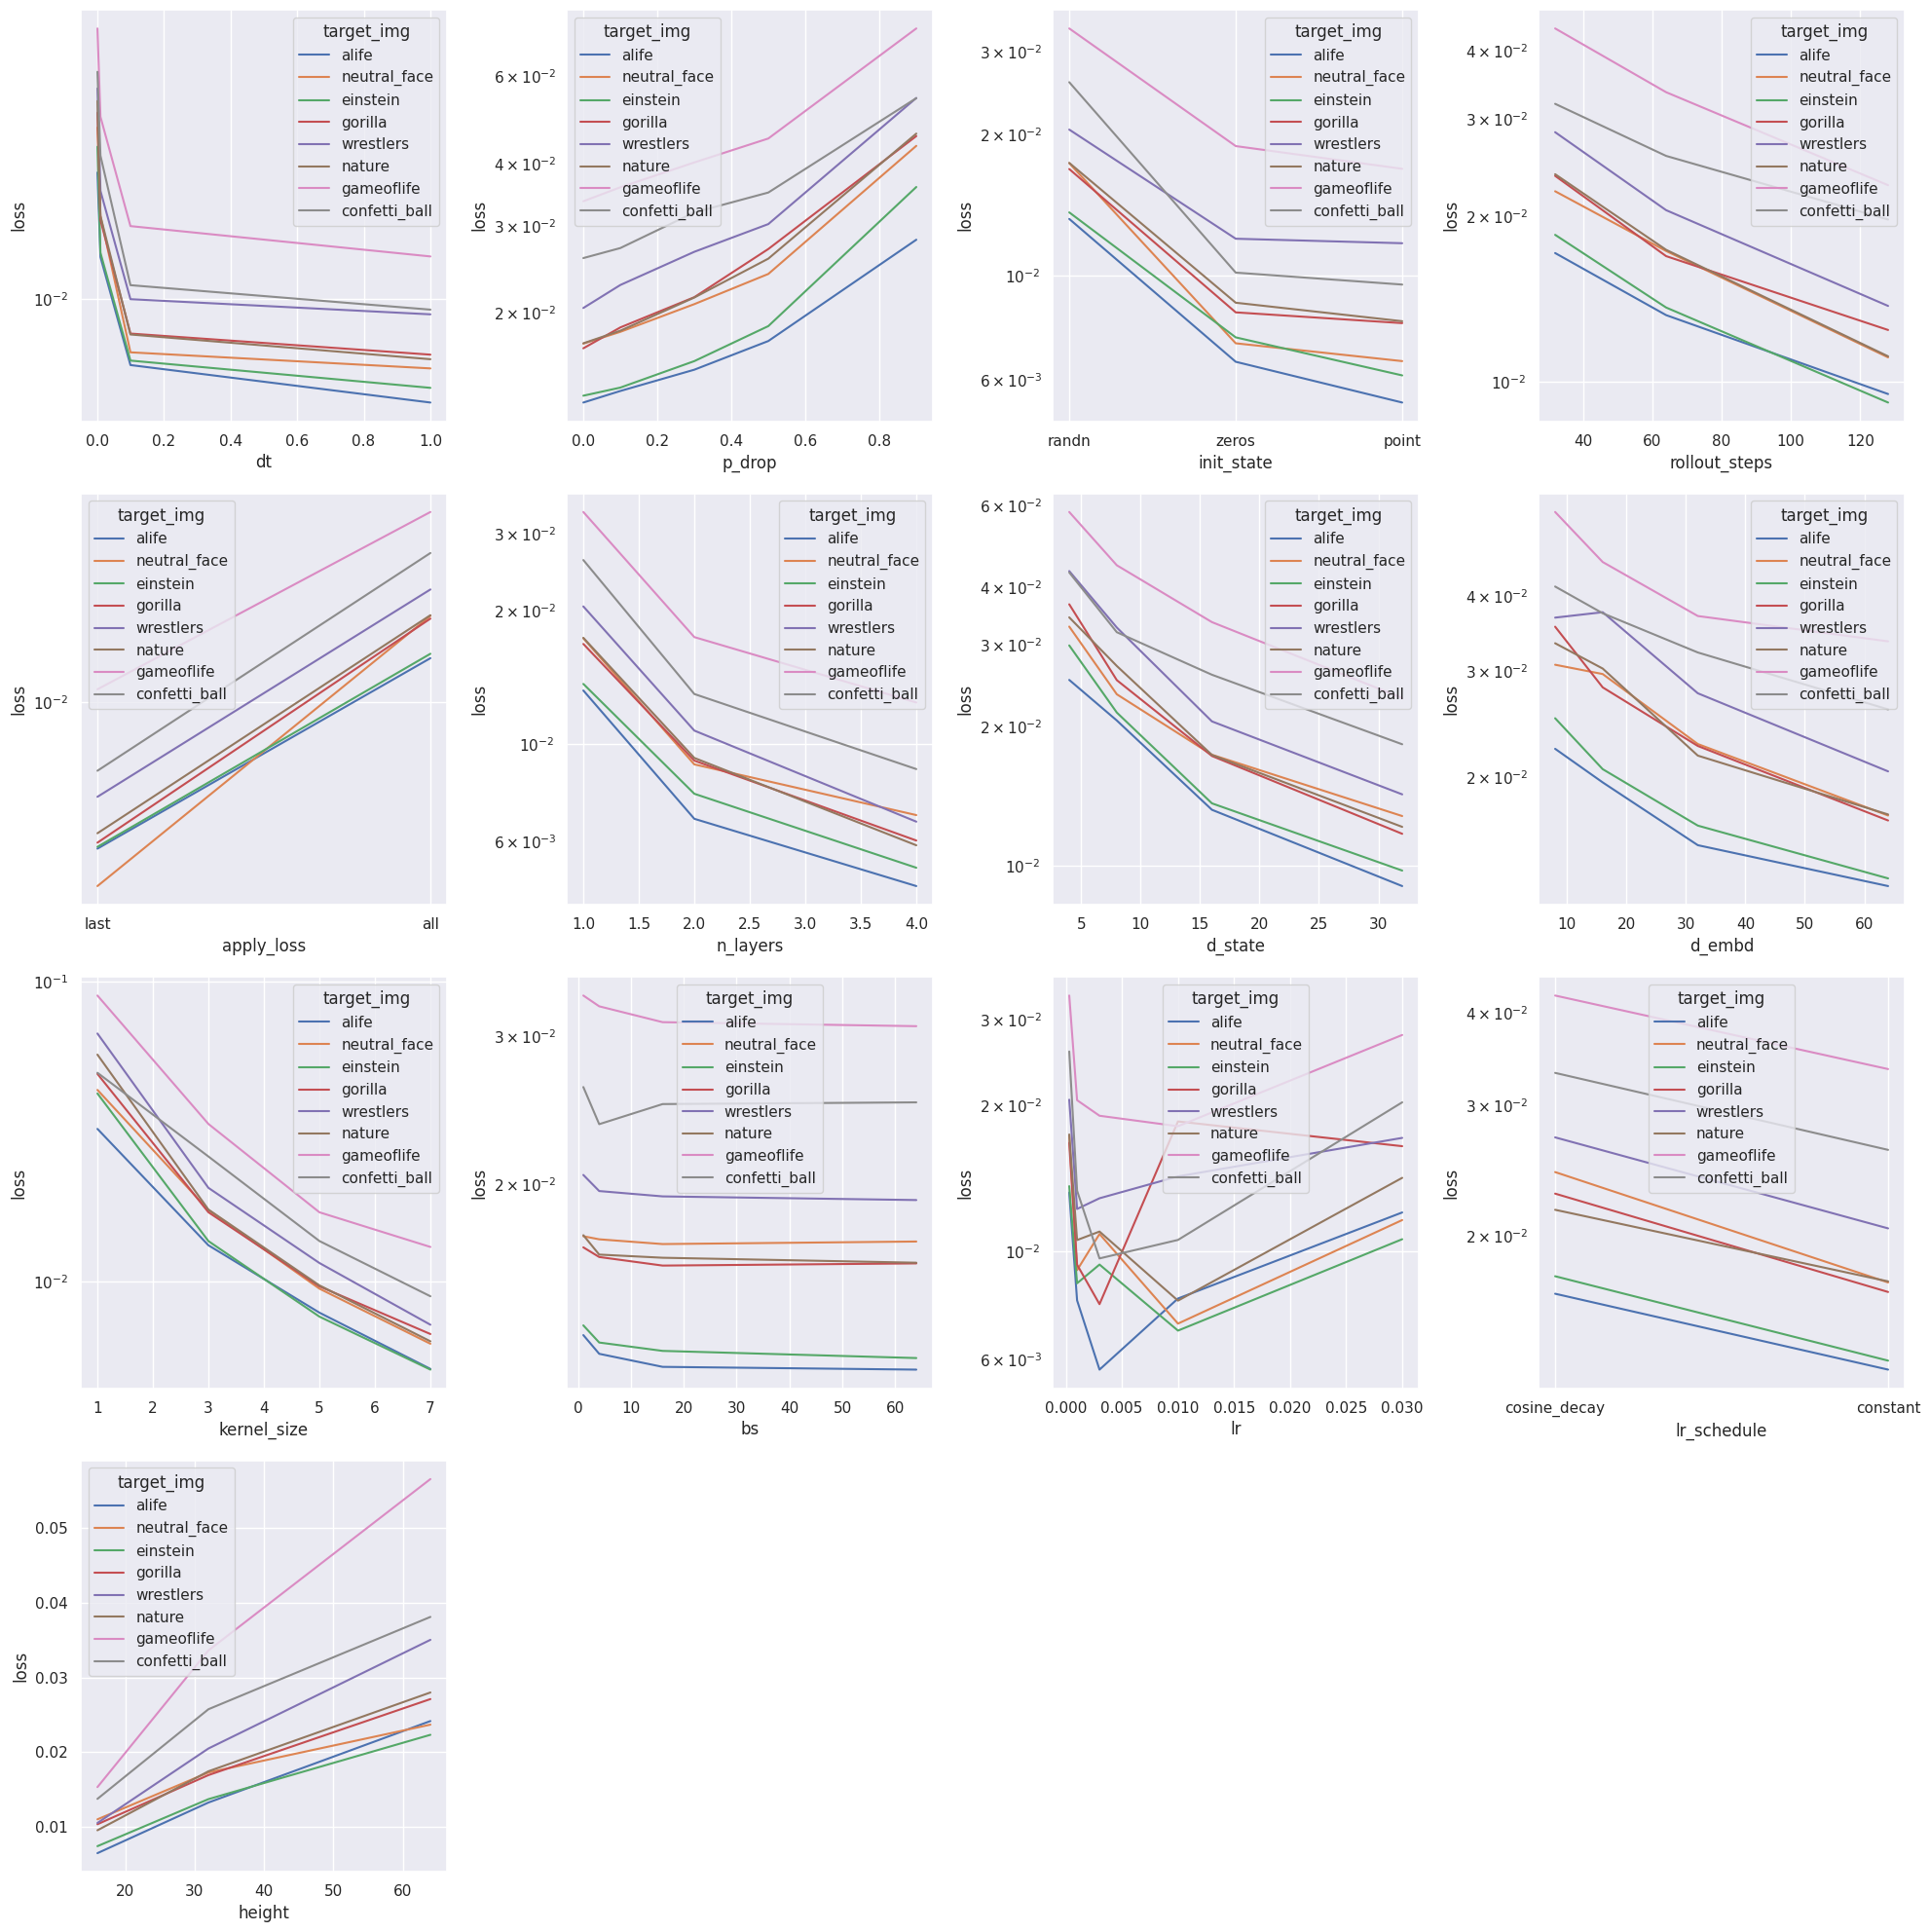

In [29]:
plt.figure(figsize=(20, 20))
for i, key in enumerate(['dt', 'p_drop', 'init_state', 'rollout_steps', 'apply_loss', 'n_layers', 'd_state', 'd_embd', 'kernel_size', 'bs', 'lr', 'lr_schedule']):
    plt.subplot(4, 4, i+1)
    sns.lineplot(data=df[df.save_dir.str.contains(f'{key}=')], x=key, y='loss', hue='target_img')
    # plt.xscale('log')
    plt.yscale('log')

plt.subplot(4, 4, i+2)
sns.lineplot(data=df[df.save_dir.str.contains(f'{"hw"}=')], x='height', y='loss', hue='target_img')

plt.tight_layout()
plt.show()

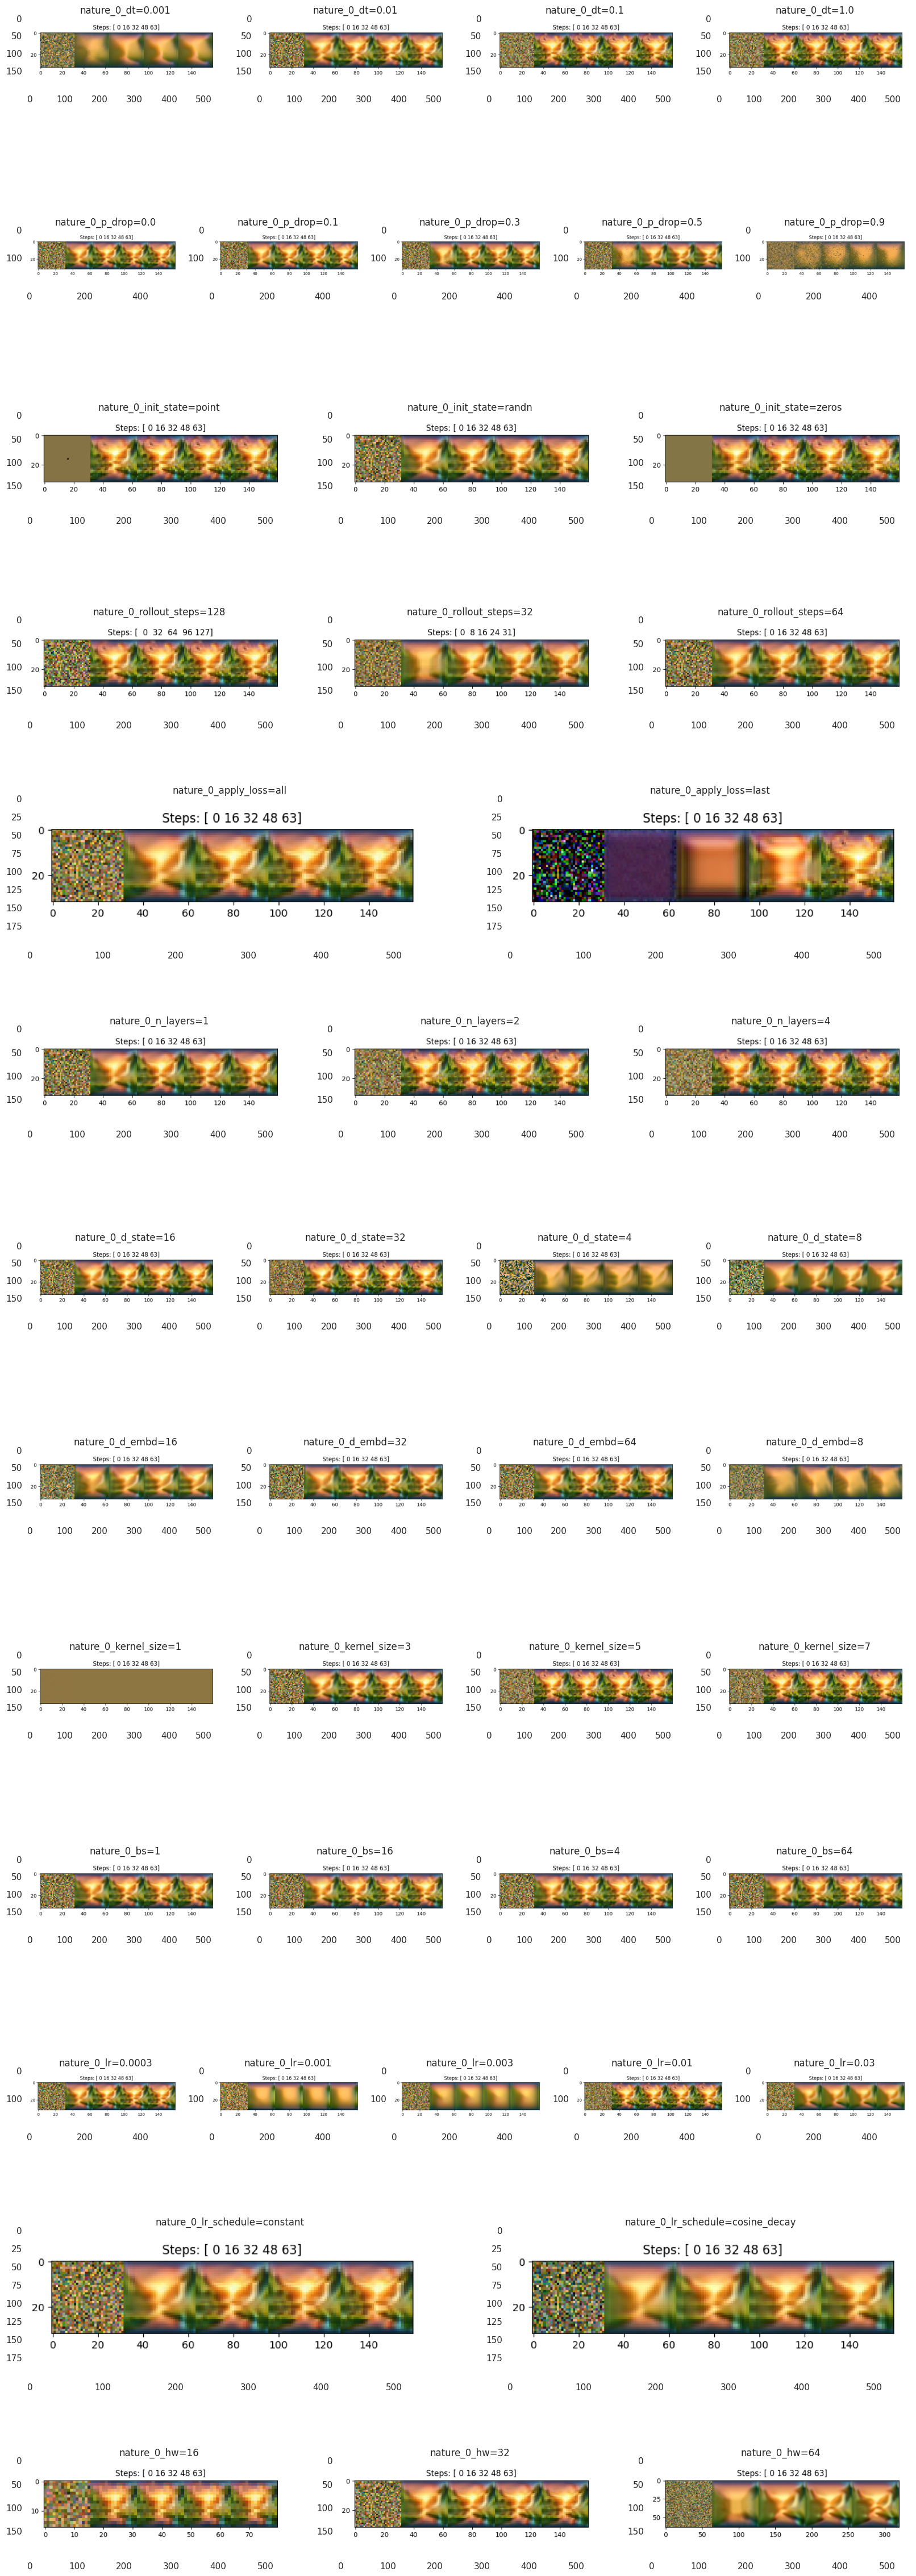

In [77]:
keys = ['dt', 'p_drop', 'init_state', 'rollout_steps', 'apply_loss', 'n_layers', 'd_state', 'd_embd', 'kernel_size', 'bs', 'lr', 'lr_schedule', 'hw']
plt.figure(figsize=(20, 60))
for i, key in enumerate(keys):
    ps = sorted(glob.glob(f'/home/akarshkumar0101/nca-alife-data/bptt/*nature*{key}=*'))
    for j, p in enumerate(ps):
        plt.subplot(len(keys), len(ps), i*len(ps)+j+1)
        args = util.load_json(p, 'args')
        a = plt.imread(f"{p}/rollout_0010000.png")
        plt.imshow(a[150:350, 50:600])
        plt.grid(False)
        plt.title(p.split('/')[-1])
plt.show()

In [69]:
import jax.numpy as jnp
def load_img(img_path, height=32, width=32):
    from PIL import Image
    img = Image.open(img_path).convert('RGB').resize((height, width))
    img = jnp.array(img, dtype=np.float32)/255.
    return img

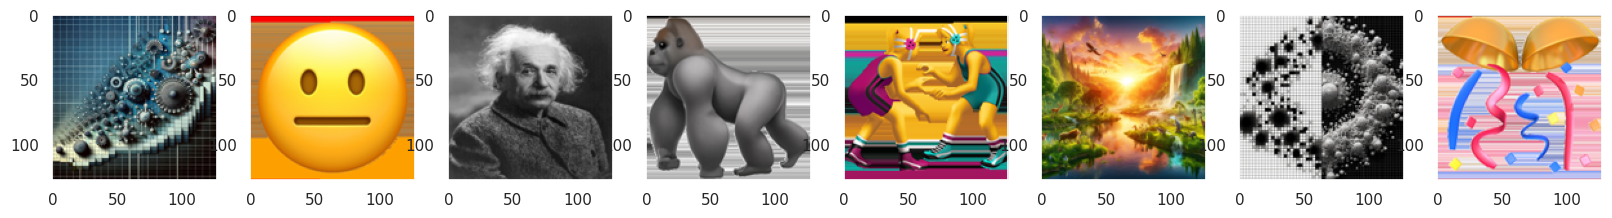

In [76]:
plt.figure(figsize=(20, 5))
ps = df.target_img_path.unique()
for i, p in enumerate(ps):
    plt.subplot(1, len(ps), i+1)
    plt.imshow(load_img(p, 128, 128))
    plt.grid(False)